In [29]:
# installing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import spacy
from nltk.tokenize import word_tokenize
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel
from PIL import Image
import requests

import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading book dataset
book = pd.read_csv('./data/Books.csv')
print(book.shape)
book.head()

(271360, 8)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
# loading ratings dataset
rating = pd.read_csv('./data/Ratings.csv')
print(rating.shape)
rating.head()

(1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
# loading users dataset
user = pd.read_csv('./data/Users.csv')
print(user.shape)
user.head()

(278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Data Cleaning and Preprocessing

In [6]:
# merging books and users data
books_df=book.merge(rating,on="ISBN")
print(books_df.shape)
books_df.head()

(1031136, 10)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0


In [7]:
# checking missing values
books_df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            4
User-ID                0
Book-Rating            0
dtype: int64

In [8]:
# dropping the missing values
books_df.dropna(axis=0, inplace=True)
print(books_df.shape)
books_df.isnull().sum()

(1031129, 10)


ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
User-ID                0
Book-Rating            0
dtype: int64

In [9]:
books_df.dtypes

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
User-ID                 int64
Book-Rating             int64
dtype: object

CONTENT-BASED FILTERING

Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback

In [10]:
# getting the dataframe to perform content-based filtering
title_df = books_df.drop_duplicates(subset=['ISBN'], keep='first')
print(title_df.shape)
title_df.head()

(270145, 10)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
15,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0
18,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0
29,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0


In [11]:
# creating dummy column for creating counts
title_df['dummy'] = np.ones(shape = title_df.shape[0])
title_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,dummy
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,1.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,1.0
15,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,1.0
18,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,1.0
29,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,1.0


In [12]:
# creating a counts column
df = title_df.groupby('Book-Title').apply(lambda grp: grp.assign(counts=lambda grp: grp['dummy'].count()))
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,dummy,counts
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,1.0,2
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,1.0,1
15,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,1.0,1
18,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,1.0,1
29,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,1.0,1


In [13]:
# getting popular books
pop_books = df[df['counts'] >= 5]
print(pop_books.shape)
pop_books.head()

(6091, 12)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,dummy,counts
30,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,8,0,1.0,5
98,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,277478,0,1.0,7
3271,0345402871,Airframe,Michael Crichton,1997,Ballantine Books,http://images.amazon.com/images/P/0345402871.0...,http://images.amazon.com/images/P/0345402871.0...,http://images.amazon.com/images/P/0345402871.0...,277965,0,1.0,5
3478,0345417623,Timeline,MICHAEL CRICHTON,2000,Ballantine Books,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,277965,0,1.0,7
3956,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,276953,10,1.0,8


We will build similarity scores based on the book title and recommend the books based on the similarity scores

Text cleaning

First we'll clean the text (book title)

In [14]:
#  creating function for normalizing the documents
def normalize_document(doc):
    # remove special characters\whitespaces
    pattern = r'[^a-zA-Z0-9\s]'
    doc = re.sub(pattern, '', doc)
    doc = doc.strip()
    doc = doc.lower()
    return doc

In [15]:
# function for removing stopwords 
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
def remove_stop(doc):
    #tokenize words
    word_tokens = word_tokenize(doc)
    #removing stopwords
    filtered_tokens = [token for token in word_tokens if token not in stopwords]
    filtered_doc = ' '.join(word for word in filtered_tokens)
    return filtered_doc

In [16]:
# data preprocessing
def data_cleaning(df):
    # cleaning title
    df['clean_title'] = df['Book-Title'].apply(lambda x: normalize_document(x)) # normalize text
    df['clean_title'] = df['clean_title'].apply(lambda x: remove_stop(x)) # remove stopwords
    return df

In [17]:
clean_df = data_cleaning(pop_books)
clean_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,dummy,counts,clean_title
30,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,8,0,1.0,5,kitchen gods wife
98,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,277478,0,1.0,7,testament
3271,0345402871,Airframe,Michael Crichton,1997,Ballantine Books,http://images.amazon.com/images/P/0345402871.0...,http://images.amazon.com/images/P/0345402871.0...,http://images.amazon.com/images/P/0345402871.0...,277965,0,1.0,5,airframe
3478,0345417623,Timeline,MICHAEL CRICHTON,2000,Ballantine Books,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,277965,0,1.0,7,timeline
3956,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,276953,10,1.0,8,kill mockingbird


In [18]:
clean_df.shape

(6091, 13)

In [19]:
clean_df['Book-Title'].value_counts()

Selected Poems                    26
Little Women                      24
Wuthering Heights                 21
Adventures of Huckleberry Finn    20
Dracula                           20
                                  ..
Mexico                             5
Mischief                           5
Uncle Tom's Cabin                  5
Forget Me Not                      5
The Kitchen God's Wife             5
Name: Book-Title, Length: 943, dtype: int64

In [20]:
# dropping duplicates
clean_df.drop_duplicates(subset='Book-Title', inplace=True)
clean_df.shape

(943, 13)

Encoding text data

We'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each book title

In [21]:
# defining a TF-IDF Vectorizer Object
tfidf = TfidfVectorizer()

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(clean_df['clean_title'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(943, 1129)

Computing similarity score

In [22]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [23]:
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [24]:
#Constructing a reverse map of indices and movie titles
'''a mechanism to identify the index of a movie in our metadata DataFrame, given its title'''
clean_df = clean_df.reset_index() # resetting index
indices = pd.Series(clean_df.index, index=clean_df['Book-Title'])

In [25]:
indices

Book-Title
The Kitchen God's Wife                                               0
The Testament                                                        1
Airframe                                                             2
Timeline                                                             3
To Kill a Mockingbird                                                4
                                                                  ... 
All That Glitters                                                  938
Facade                                                             939
Rumpelstiltskin                                                    940
Land of Oz                                                         941
Phonics Fun: Reading Program, Pack 4 (Clifford the Big Red Dog)    942
Length: 943, dtype: int64

Creating a function that takes in a book title and gives out a list of similar books.

Steps to be followed:

- Get the index of the book given its title.
- Get the list of cosine similarity scores for that particular book with all books. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
- Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
- Get the top 10 elements of this list. Ignore the first element as it refers to self (the book most similar to a particular book is the book itself).
- Get the list titles corresponding to the indices of the top elements.
- Create a subplot for the images of the top 10 similar books


In [64]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Getting the index of the book that matches the title
    idx = indices[title]

    # Getting the pairwsie similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    # getting similar books
    similar_books = clean_df['Book-Title'].iloc[book_indices].tolist()
    # getting book images
    fig,ax=plt.subplots(1,10,figsize=(17,5))
    fig.suptitle("WOULD YOU LIKE TO TRY THESE BOOKS?",fontsize=30,color="deepskyblue")
    for i in range(len(similar_books)): # iterating over length of books
        url = clean_df.loc[clean_df['Book-Title']==similar_books[i], 'Image-URL-L'][:1].values[0] # getting book url
        img=Image.open(requests.get(url,stream=True).raw)
        ax[i].imshow(img)
        ax[i].axis("off")
        fig.show()
    

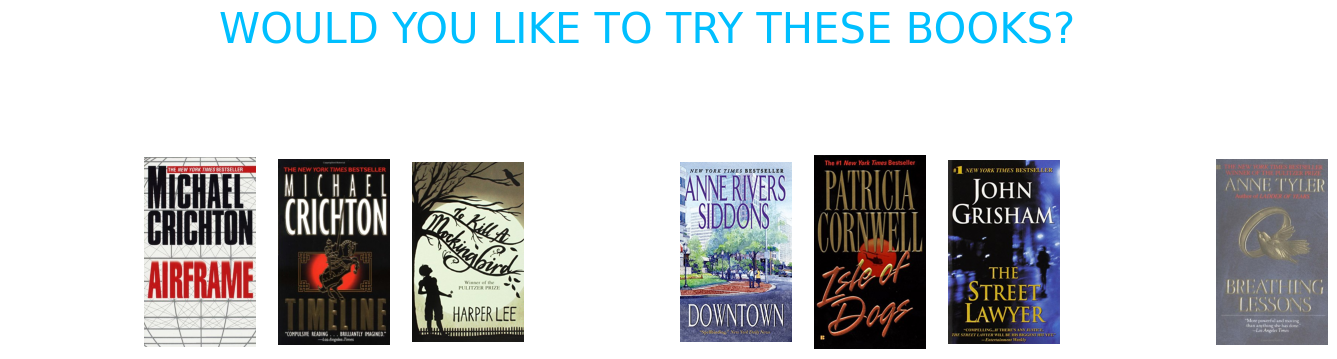

In [65]:
get_recommendations('The Testament')

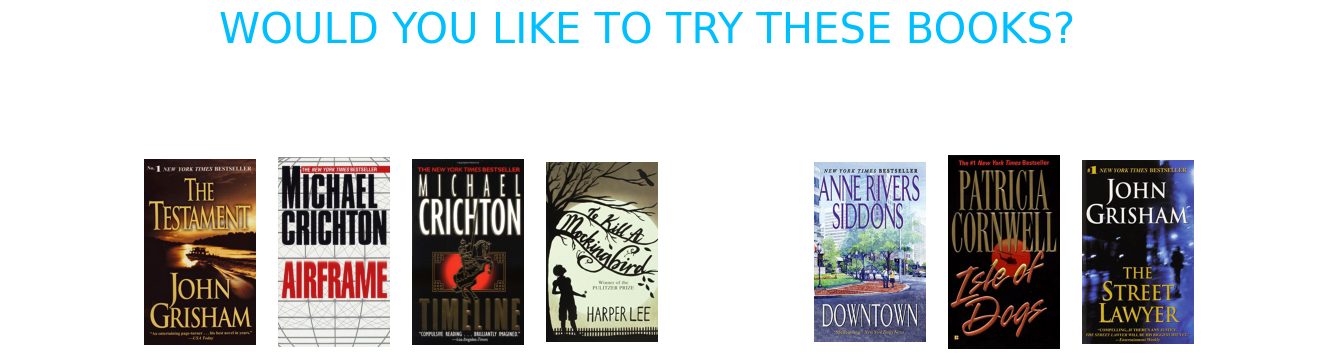

In [66]:
get_recommendations('Facade')

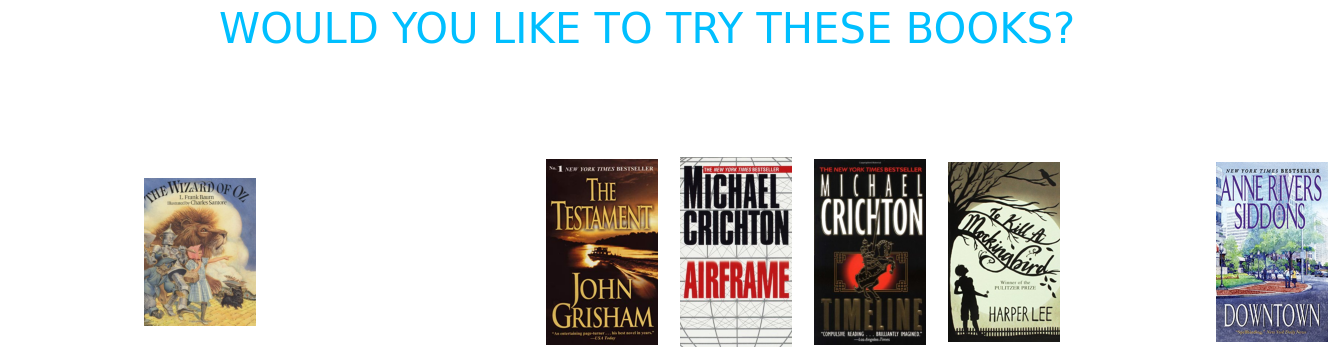

In [67]:
get_recommendations("Land of Oz")

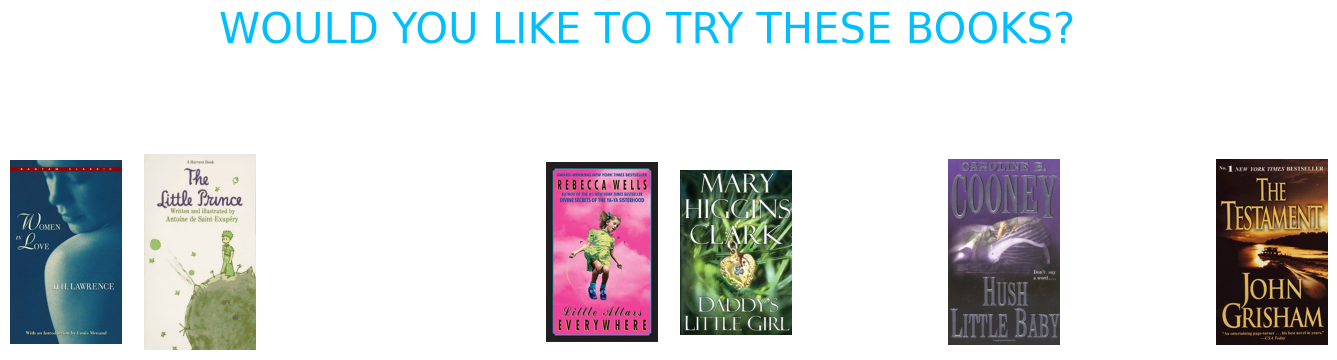

In [68]:
get_recommendations("Little Women")